# Arbre de mixture gaussienne

*Authors : Théo Duquesne, Taliesine Gueye, Navarre Victor et Benjamin Pineau*

Ceci réalise un EM à 30 classes des étoiles

Le principe est de constater que, avec beaucoup de classes, la classif est très bonne
L'idée serait ensuite de réunir ces classes par similarité, afin de de résuire leur nombre et d'arriver (optimalement) à 6 classes

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import collections
import pandas as pd

In [94]:
import mesures
from mesures import mesure_quantiles
star_num_ns = pd.read_csv('/content/star_numérique_non_supervisé(1).csv')
#star_num_ns = star_num_ns.to_numpy()
star_num_ns.head()
Y_goal_pd = pd.read_csv('/content/valeurs cibles.csv')


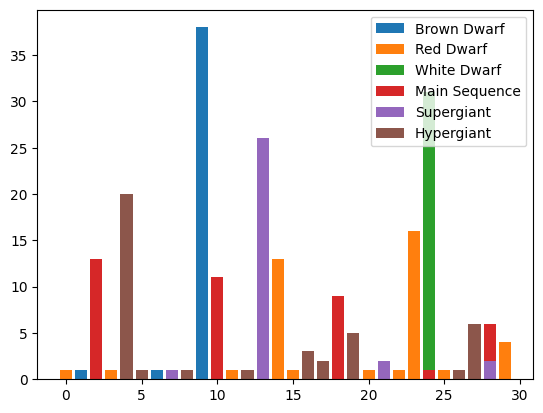

In [95]:
star_num_ns_tab = star_num_ns.to_numpy()
star_cat = np.array(['Brown Dwarf', 'Red Dwarf', 'White Dwarf', 'Main Sequence',
       'Supergiant', 'Hypergiant'])
Y_goal = Y_goal_pd.to_numpy()

n_compo = 30
GMM_star_categorielle = GaussianMixture(n_components =n_compo, covariance_type='diag', init_params = 'random_from_data')
GMM_star_categorielle.fit(star_num_ns_tab)
Y_pred = GMM_star_categorielle.predict(star_num_ns_tab)
probs = GMM_star_categorielle.predict_proba(star_num_ns_tab)
res = []
for i in range (len(Y_pred)):
  res+=[[str(Y_pred[i]), Y_goal[i]]]

abs=[i for i in range((n_compo))]
for e in star_cat:
  valeurs_e = np.zeros(n_compo)
  for i in range(n_compo):
    valeurs_e[i]=0
    for j in range(len(res)):
      if res[j][0]==str(i) and res[j][1]==e:
        valeurs_e[i]+=1
  plt.bar(abs, valeurs_e, label=e)
plt.legend()
plt.show()
#print(res)



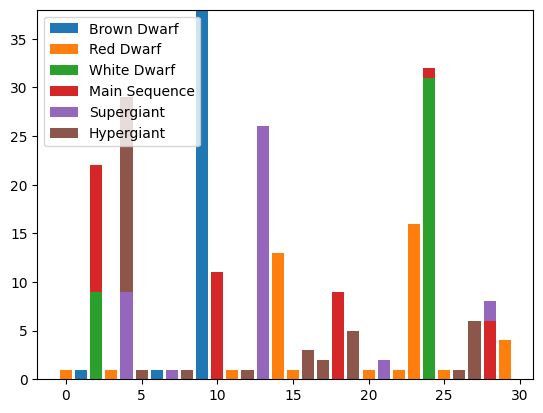

In [96]:
abs = [i for i in range(n_compo)]

bottom = np.zeros(n_compo)  # Initialize the bottom for stacking

for e in star_cat:
    valeurs_e = np.zeros(n_compo)
    for i in range(n_compo):
        valeurs_e[i] = 0
        for j in range(len(res)):
            if res[j][0] == str(i) and res[j][1] == e:
                valeurs_e[i] += 1
    plt.bar(abs, valeurs_e, bottom=bottom, label=e)  # Stack bars using 'bottom'
    bottom += valeurs_e  # Update the bottom for the next category

plt.legend()
plt.show()

On se propose de fusionner les deux classes les plus proches et de voir si tout fonctionne bien.

Comment mesurer la proximité entre deux classes ?


on importe la mesure choisit (il faut avoir le fichier avec les mesures)

In [97]:
def indice_min(matrice):
  n=len(matrice)
  p=len(matrice[0])
  min = matrice[0][0]
  indice = [0,0]
  for i in range(n):
    for j in range(p):
      if matrice[i][j]<min:
        min = matrice[i][j]
        indice = [i,j]
  return(indice)


In [98]:


def reunir_groupes(points, groupe, moyennes, matrices_de_covariances, mesure= mesure_quantiles, nombre_gpe_final = 6) :
  n_gpe = len(np.unique(groupe))
  Y_reunis = groupe.copy() #vecteur de taille len(points), qui stocke la valeur de la classe de chacun des points)
  liste_groupe = np.unique(groupe) #on liste les n_gpe groupes
  liste_groupe_final = liste_groupe #on attribue à chaque groupe initial un groupe final
  print('groupe', groupe)
  (points[groupe==0])
  #on crée une matrice des distances
  matrice_distances = 2*np.ones((n_gpe, n_gpe))

  for i in range(n_gpe):
    for j in range(n_gpe):
      if i != j :
        X_i = points[groupe==i]
        if len(X_i)==0:
          return('feuuuur', 'i=', i, 'et j', j)
        Y_i = np.array([i for k in range(len(X_i))])
        X_j = points[groupe==j]
        if len(X_j)==0:
          return('feuuuur', 'j=', j,'et i',i)
        Y_j = np.array([j for k in range(len(X_j))])
        X=np.concatenate((X_i, X_j))
        Y=np.concatenate((Y_i, Y_j))
        moyenne_i  = moyennes[i]
        moyenne_j  = moyennes[j]
        cov_i = matrices_de_covariances[i]
        cov_j = matrices_de_covariances[j]
        matrice_distances[i][j] = 1-mesure(X,Y, 0.1, mu_a = moyenne_i, Sigma_a = cov_i, mu_b = moyenne_j, Sigma_b = cov_j, parametres_forcees=True)

  max_plus_1= np.max(matrice_distances)+1
  matrice_distances[matrice_distances<=0.045]=max_plus_1
  print(matrice_distances)
  print('feur')
  print(matrice_distances[2])
  i=0
  flag=True
  while i<n_gpe - nombre_gpe_final and flag:
    i+=1
    #on selectionne la distance minimale entre deux sous groupes
    a_min,b_min = indice_min(matrice_distances)
    print('a_min',a_min, 'b_min', b_min)
    a_min_gpe, b_min_gpe = liste_groupe[a_min], liste_groupe[b_min]
    print('a_min_gpe',a_min_gpe, 'b_min_gpe', b_min_gpe)
    #on fusionne A et B
    nouveau_groupe = min(a_min_gpe, b_min_gpe)

    print('nouveau groupe', nouveau_groupe)
    liste_groupe_final[liste_groupe_final==b_min]=nouveau_groupe
    liste_groupe_final[liste_groupe_final==a_min]=nouveau_groupe


    #on met à jour la matrice des distances afin de ne pas avoir à refusionner des groupes qui le sont déjà
    for p in range(n_gpe):
      for q in range(n_gpe):
        if liste_groupe_final[p] == liste_groupe_final[q]: #pour chaque sous-groupes p et q, si ils sont dans le même grand groupe, on met une grande distance entre les deux
          matrice_distances[p][q]=max_plus_1

    if np.min(matrice_distances)>=1:
      flag=False
      print('min=',np.min(matrice_distances))
      print('argmin =', indice_min(matrice_distances))
    print('liste temporaire',i, liste_groupe_final)

  print('liste finale',liste_groupe_final)
  print('i=', i)
  for i in range(len(groupe)):
    Y_reunis[i]=liste_groupe_final[groupe[i]]
  print('code executé')

  return(Y_reunis)


In [99]:
quantite_test = 10
moys= GMM_star_categorielle.means_
print(moys[0])
print(GMM_star_categorielle.covariances_[0])
covs= [np.diagflat(GMM_star_categorielle.covariances_[i]) for i in range(n_compo)]
Y_finaaaaaaal = reunir_groupes(star_num_ns_tab, Y_pred, moys, covs, nombre_gpe_final=quantite_test)




[2.621e+03 6.000e-04 9.800e-02 1.281e+01 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[1.01583248e-06 1.00000000e-06 1.00000000e-06 1.00000040e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06 1.00000000e-06 1.00000000e-06 1.00000000e-06
 1.00000000e-06]
groupe [ 9  9  9  9  9  9  9  9  9  9 14 23 29 14 11 23 25 14 29 14 24 24  2 24
 24  2 24  2  2  2 28 10 10 24  2  2  2  2  2  2  4  4  4  4  4  4  4  4
  4 28  4  4  4 16  4  4  4  4  4  4  9  9  9  9  9  9  9  9  9  9 20 14
 23 23 14 23 15 23  0 29  2  2 24 24 24 24 24 24  2 24  2  2  2  2 18 18
  2  2 18 28 28 13 13 13 13 13 13 13 13 13  4  4  4  4  4  4  8

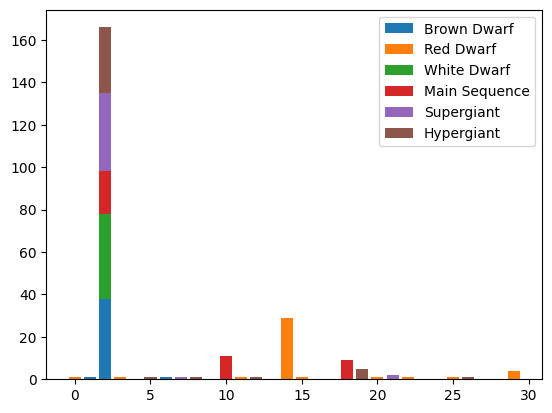

21


In [100]:
cat_finales = np.unique(Y_finaaaaaaal)
abs = [i for i in range(n_compo)]
long_absc = len(cat_finales)

bottom = np.zeros(n_compo)  # Initialize the bottom for stacking

for e in star_cat:
    valeurs_e = np.zeros(n_compo)
    for i in cat_finales:

        valeurs_e[i] = 0
        for j in range(len(Y_finaaaaaaal)):
            if Y_goal[j] == e and Y_finaaaaaaal[j] == i:
                valeurs_e[i] += 1
    plt.bar(abs, valeurs_e, bottom=bottom, label=e)  # Stack bars using 'bottom'
    bottom += valeurs_e  # Update the bottom for the next category

plt.legend()
plt.show()
print(len(cat_finales))